# All KNN

Adapts the functionality of Repeated Edited Nearest Neighbours in that, at each round, it increases the number of neighbours utilised to exclude or retain the observations.


1) Train a 3 KNN algorithm on the entire dataset

2) Check all observations from majority class and remove observations if its class is different from that of its (3) neighbours

3) Train a 4 KNN algorithm on the remaining samples.

4) Go to 2 and repeat. Every time you reach 3, add a neighbour to the KNN.

Adding a neighbour at each iteration makes the criteria for a sample to be retained harder and harder, therefore removing more observations that are closer to the boundary to the minority class.

In this notebook, we will compare ENN, RENN, and AllKNN.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import (
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN
)

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Undersample with AllKNN

https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.AllKNN.html


### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up All KNN

allknn = AllKNN(
    sampling_strategy='auto',  # undersamples only the majority class
    n_neighbors=3,
    kind_sel='all',  # all neighbours need to have the same label as the observation examined
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = allknn.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((970, 2), (970,))

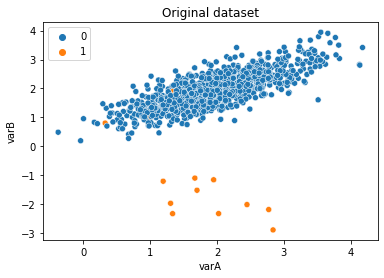

In [6]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

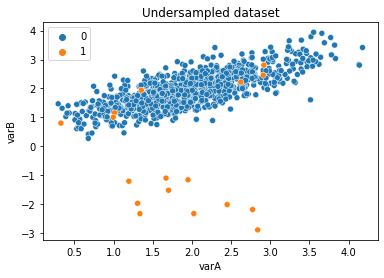

In [7]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset')
plt.show()

Note how some yellow dots can now be seen clearer, as their neighbouring observations from the other class were removed from the data set.

### Partially separated classes

Let's repeat the same exercise in data where the classes are not so clearly separated. 

In [8]:
# create data
X, y = make_data(sep=0)

# set up All KNN

allknn = AllKNN(
    sampling_strategy='auto',  # resamples the majority class
    n_neighbors=3,
    kind_sel='all',  # all neighbours need to agree
    n_jobs=4)  # I have 4 cores in my laptop


X_resampled, y_resampled = allknn.fit_resample(X, y)

In [9]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# undersampled data

X_resampled.shape, y_resampled.shape

((947, 2), (947,))

As the classes are not so clearly distinguished, more samples were removed from the dataset.

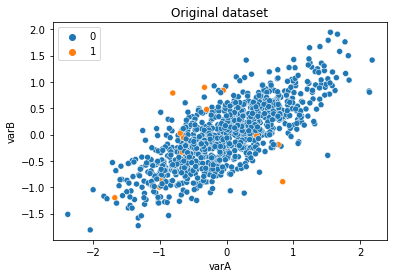

In [11]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

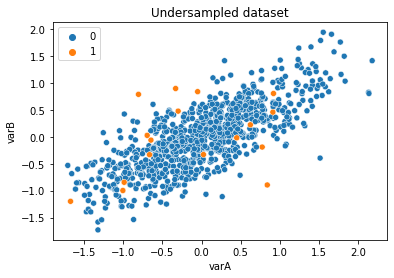

In [12]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

Notice again, that observations have been cleared from the surroundings of those of the minority class. 

The closer the classes are, the more observations that are removed.

## All KNN

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [13]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
85224,75.59,26.73,-1.44,-6.0,43.5,1052.4,0.18,1.75,25.5,-75.0,...,723.1,0.75,2.92,11.0,-52.0,370.5,0.29,0.31,0.13,-1
95800,70.34,31.43,0.62,-2.0,-23.0,1520.5,-1.37,0.09,-1.5,-64.0,...,622.4,1.48,-1.16,-6.0,-36.0,319.5,0.52,0.36,0.35,-1
20517,60.53,26.00,-0.61,29.0,4.0,1325.6,0.31,-0.12,-3.0,-77.0,...,905.2,1.17,-0.69,-14.0,-77.0,936.5,0.15,0.24,0.21,-1
117081,53.18,30.61,-1.02,-29.5,65.0,2590.1,-0.01,-0.28,-5.0,-87.5,...,2822.4,1.08,0.33,-3.0,-77.0,1213.0,-1.48,0.05,0.93,-1
138341,76.00,26.80,-0.34,-28.5,24.0,548.0,1.84,2.75,16.0,-76.5,...,693.4,0.19,-1.35,-2.0,-44.0,563.0,-1.04,0.16,0.10,-1


In [14]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.9927
 1    0.0073
Name: target, dtype: float64

In [15]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

In [16]:
# edited nearest neighbours

enn = EditedNearestNeighbours(
    sampling_strategy='auto',  # resamples the majority class
    n_neighbors=3,
    kind_sel='all',  # all neighbours need to agree
    n_jobs=4)  # I have 4 cores in my laptop

X_enn, y_enn = enn.fit_resample(X_train, y_train)

In [17]:
# repeated NN

renn = RepeatedEditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=4,
    max_iter=100)  # I hve 4 cores in my laptop

X_renn, y_renn = renn.fit_resample(X_train, y_train)

In [18]:
# All KNN

allknn = AllKNN(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=4,
)  # I hve 4 cores in my laptop

X_allknn, y_allknn = allknn.fit_resample(X_train, y_train)

In [19]:
# compare shapes

X_train.shape, X_enn.shape, X_renn.shape, X_allknn.shape

((7000, 74), (6942, 74), (6933, 74), (6936, 74))

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [20]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [21]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.998013778247006
Test set
Random Forests roc-auc: 0.9508642454845601


In [22]:
# evaluate performance of algorithm built
# using enn undersampled dataset

run_randomForests(X_enn,
                  X_test,
                  y_enn,
                  y_test)

Train set
Random Forests roc-auc: 0.9896196283391406
Test set
Random Forests roc-auc: 0.9583855647168912


In [23]:
# evaluate performance of algorithm built
# using renn undersampled dataset

run_randomForests(X_renn,
                  X_test,
                  y_renn,
                  y_test)

Train set
Random Forests roc-auc: 0.9971114449236269
Test set
Random Forests roc-auc: 0.9552605095428945


In [24]:
# evaluate performance of algorithm built
# using renn undersampled dataset

run_randomForests(X_allknn,
                  X_test,
                  y_allknn,
                  y_test)

Train set
Random Forests roc-auc: 0.9953286619953288
Test set
Random Forests roc-auc: 0.9544306926322852


Performance seems to improve.